The essence of machine learning is to take some data from the past, use (and maybe build) and algorithm to discover patterns in those data, and then use that algorithm to predict the future. 

# linear

In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt

print(f'using version {torch.__version__}')


using version 1.12.1


### Preparing and loading data

#### There are two basic parts to training a model:
- Turn your data into numbers
- Pick or build a model that can learn from those numbers

Here we will use linear regression to create data with known parameters, and then create a model to learn those parameters.

In [2]:
# 'Known" parameters:
weight = 0.7
bias = 0.3

# Generate some data
start = 0
end = 1
step = 0.02
''' 
 A couple things to point out here:
 1) X is capitalized because X generally refers to a matrix 
 2) We need unsqueeze here (without it we would have a vector) but I'm not sure why.
 3) The linear regression equation is y = (weight)*x + bias
'''
X = torch.arange(start, end, step)
print(f'Shape of X is {X.shape}')
X = X.unsqueeze(dim=1)
print(f'Shape of X is {X.shape}')
y = X * weight + bias

# let's view the first 5 values from each matrix:
print(X[:5])
print(y[:5])

Shape of X is torch.Size([50])
Shape of X is torch.Size([50, 1])
tensor([[0.0000],
        [0.0200],
        [0.0400],
        [0.0600],
        [0.0800]])
tensor([[0.3000],
        [0.3140],
        [0.3280],
        [0.3420],
        [0.3560]])


Now we have `X`(features) and `y`(labels) so we can begin building a model that will learn the relationship between `X` and `y`.

### Train Test Split

#### Training data
- `Amount:` 60-90% of the data
- `Required?` Yes
- The model learns from this data. There is no learning without training data. After each epoch, the model loss is calculated based on the training data and the model parameters are adjusted accordingly.

#### Validation data
- `Amount:` 10-20% of the data
- `Required?` Usually, but not always
- The validation data is used during training to evaluate the ability of the model to generalize. The model loss is also calculated from the validation data, but the model parameters are `not` adjusted as a consequence. The validation loss is used to determine when to stop training. If the validation loss starts to increase, it is a sign that the model is overfitting and we should stop training.

#### Test data
- `Amount:` 10-20% of the data
- `Required?` Yes
- The test data is used to evaluate the final model. The test data is only used once, after the model has been trained. The test data is not used to adjust the model parameters or to determine when to stop training. The test data is used to evaluate the model's ability to generalize to new data.

For this project we won't use a validation set. We will just train on the training data and test and the test data. To start, let's split the test and train data:

In [9]:
# test train split:
train_split = int(0.8 * len(X))
X_train = X[:train_split]
y_train = y[:train_split]
X_test = X[train_split:]
y_test = y[train_split:]

print(len(X_train), len(y_train), len(X_test), len(y_test))

40 40 10 10


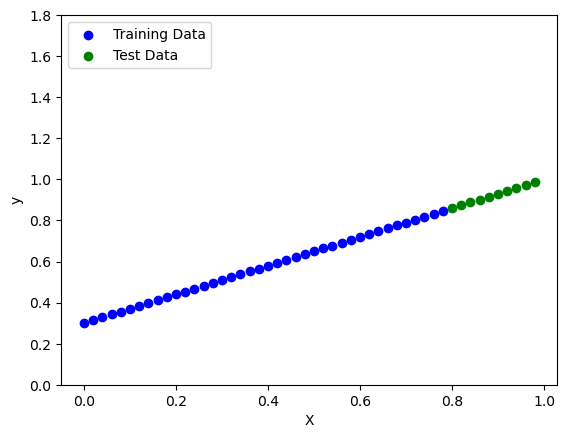

In [103]:
# let's create a function to plot the data:

def plot_data(train_data = X_train,
              train_labels = y_train,
              test_data = X_test,
              test_labels = y_test,
              predictions = None,
              save = False,
              epoch_num = 0):
    fig, ax = plt.subplots()
    ax.scatter(train_data, train_labels, c='b', label='Training Data')
    ax.scatter(test_data, test_labels, c='g', label='Test Data')
    if predictions is not None:
        ax.scatter(test_data, predictions, c='r', label='Predictions')
    # legend in top left
    ax.legend(loc='upper left')
    ax.set_xlabel('X')
    ax.set_ylabel('y')
    ax.set_ylim([0, 1.8])
    if save:
        fig.savefig(f'LG_plots/epoch{epoch_num}.png')
        plt.close(fig)
        return
    else:
        plt.show()
        # close the figure
        plt.close(fig)

plot_data()

### PyTorch model building essentials

- `torch.nn` is the PyTorch neural network library. It provides the building blocks to create neural networks.
- `nn.Parameter` stores tensors that can be used with `nn.Module`. If `requires_grad=True`, the gradients are calculated automatically.
- `nn.Module` is the base class for all neural network modules. It provides a common interface for all neural network modules. It also provides a mechanism for automatically registering parameters and submodules. Requires that a `forward` method is implemented.
- `torch.optim` is the PyTorch optimization library. It provides the building blocks to create optimizers. Optimizers tell the models stored in nn.Parameter how best to improve gradient descent and decrease loss.
- `def forward()` all nn.Module() subclasses require this method; it defines the computation that will take place on the data passed to the module. 

In [122]:
### Build the model:
class LinearRegressionModel(nn.Module): # <- Almost everything in PyTorch is a nn.Module subclass
    def __init__(self):
        super().__init__()              # <- Inherit from the parent class constructor

        self.weights = nn.Parameter(torch.rand(1,       # start with a random weight that gets adjusted as the model learns
                                requires_grad=True,     # we want to be able to adjust this weight
                                dtype=torch.float32 
        ))
        self.bias = nn.Parameter(torch.rand(1,          # start with a random bias that gets adjusted as the model learns
                                requires_grad=True,     # we want to be able to adjust this bias
                                dtype=torch.float32 
       ))

    # forward defines the computation used in the model
    def forward(self, x: torch.tensor) -> torch.tensor: # <- x is the input data
        return self.weights * x + self.bias             # <- y = (weight)*x + bias  

# set random seed since the weights and biases are initialized randomly:
torch.manual_seed(42)

# create an instance of the model:
model_0 = LinearRegressionModel()

# check the parameters within the nn.Module subclass that we created. NOTE this is a generator, so we need to list it:
print(list(model_0.parameters()))

# we can also get the "state" of the model using the state_dict method:
print(model_0.state_dict())

[Parameter containing:
tensor([0.8823], requires_grad=True), Parameter containing:
tensor([0.9150], requires_grad=True)]
OrderedDict([('weights', tensor([0.8823])), ('bias', tensor([0.9150]))])


### Making predictions

To check predictions, we can pass our x_test data to the model. Any data that we pass will go through the model's forward method and return the result of the computation that we have defined.

In [123]:
# torch.inference_mode() turns off a bunch of things (like gradient tracking, 
# #which is necessary for training but not for inference) to make forward-passes 
# (data going through the forward() method) faster.
with torch.inference_mode():
    y_pred = model_0(X_test)
    print(y_pred)

tensor([[1.6208],
        [1.6385],
        [1.6561],
        [1.6738],
        [1.6914],
        [1.7090],
        [1.7267],
        [1.7443],
        [1.7620],
        [1.7796]])


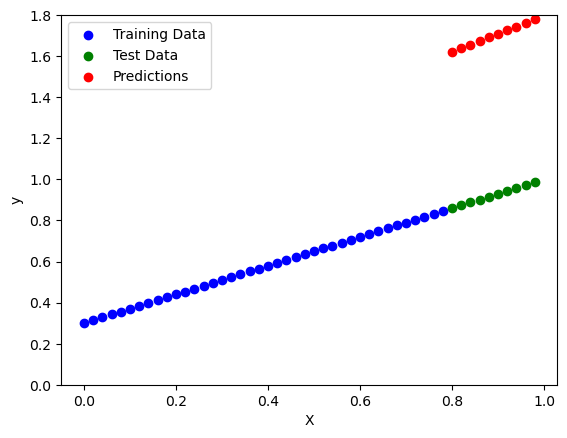

In [124]:
plot_data(predictions=y_pred)

### Train the model - Creating a loss function and optimizer in PyTorch

#### Loss function
- Measures how wrong your predictions are compared to ground truth
- PyTorch has plenty of built-loss functions in `torch.nn`
- commonly set to Mean Absolute Error MAE (`torch.nn.L1Loss()`) for regression or binary cross entropy (`torch.nn.BCELoss()`) for binary classification

#### Optimizer
- Tells the model how best to update its internal parameters to minimize loss
- PyTorch has plenty of built-in optimizers in `torch.optim`
- commonly set to stochastic gradient descent (`torch.optim.SGD()`) or Adam (`torch.optim.Adam()`)

In [125]:
# loss function:
loss_fn = nn.L1Loss()   # <- L1Loss is the same as MAE (mean absolute error)

# optimizer:
learning_rate = 0.01    # <- this is the learning rate, common values are 0.1, 0.01, 0.001, etc.
optimizer = torch.optim.SGD(params = model_0.parameters(),
                            lr = 0.001)

### Create an optimization loop:

The optimization loop involves both a `training loop`, where the model creates predictions and calculates losses based on the training data, as well as a a `testing loop` which involves the same thing on the test data. 

#### Training loop

- `Forward pass`: use `model(x_train)` to go through all the training data once, using the computation defined in the model's forward method.
- `Calculate loss`: use `loss = loss_fn(y_pred, y_train)` to compare the calculations to the ground truth and see how wrong they are.
- `Zero Gradients`: use `optimizer.zero_grad()` to reset the gradients to zero (they are accumulated by default) before calculating the new gradients.
- `Back propagation`: use `loss.backward()` to calculate the gradients of the loss with respect to each of the model's parameters.
- `Update weights`: use `optimizer.step()` to update the model's parameters using the gradients calculated in the previous step.

NOTE: While the above is a good default, the specific ordering of events is flexible. Some good rules of thumb are:
- Calculate the loss before performing backpropagation
- Zero the gradients before calculating the new gradients
- Update the weights after calculating the new gradients

#### Testing loop
- `Forward pass`: use `model(x_train)` to go through all the training data once, using the computation defined in the model's forward method.
- `Calculate loss`: use `loss = loss_fn(y_pred, y_train)` to compare the calculations to the ground truth and see how wrong they are.
- `Calculate evaluation metrics`: Alongside the loss, you may want to calculate other metrics such as accuracy using custom eval functions

In [126]:
model_0.train()
print(f'model params are {list(model_0.parameters())}')
y_pred = model_0(X_train)
loss = loss_fn(y_pred, y_train)
loss.backward()
print(f'model params are {list(model_0.parameters())}')
optimizer.step()
print(f'model params are {list(model_0.parameters())}')


model params are [Parameter containing:
tensor([0.8823], requires_grad=True), Parameter containing:
tensor([0.9150], requires_grad=True)]
model params are [Parameter containing:
tensor([0.8823], requires_grad=True), Parameter containing:
tensor([0.9150], requires_grad=True)]
model params are [Parameter containing:
tensor([0.8819], requires_grad=True), Parameter containing:
tensor([0.9140], requires_grad=True)]


In [127]:
torch.manual_seed(42)

epochs = 1000           # <- number of times we go through the entire training set   

# create some empty loss lists so we can track the training and validation losses:
train_losses = []
test_losses = []
epoch_num = []

for epoch in range(epochs):

    ### Training loop ###
    model_0.train()                     # <- put the model in training mode
    y_pred = model_0(X_train)           # <- predictions; this is a tensor of the same shape as y_train
    loss = loss_fn(y_pred, y_train)     # <- scalar tensor describing the loss
    optimizer.zero_grad()               # <- zero the gradients 
    loss.backward()                     # <- calculate the gradients
    optimizer.step()                    # <- update the model parameters

    model_0.eval()                      # If there are any specific layers that behave differently during training and inference,
                                        # we need to tell the model to put those layers in inference mode.
    with torch.inference_mode():        # <- this is the same as torch.no_grad(), but has better performance

        test_pred = model_0(X_test)             # <- predictions; this is a tensor of the same shape as y_test
        test_loss = loss_fn(test_pred, y_test)  # <- scalar tensor describing the loss

        if epoch % 10 == 0:                     # <- record and print the loss every 10 epochs
            '''
            plot_data(predictions=test_pred,    # <- save the predictions for the epoch
                    save=True,                  # uncomment this is you want to save new plots
                    epoch_num=epoch
                    )
            '''
            epoch_num.append(epoch)
            train_losses.append(loss.item())
            test_losses.append(test_loss.item())
            print(f'epoch: {epoch} | MAE train loss: {round(loss.item(), 6)} | MAE test loss: {round(test_loss.item(), 6)}')

epoch: 0 | MAE train loss: 0.684937 | MAE test loss: 0.774529
epoch: 10 | MAE train loss: 0.673416 | MAE test loss: 0.761059
epoch: 20 | MAE train loss: 0.661895 | MAE test loss: 0.747588
epoch: 30 | MAE train loss: 0.650374 | MAE test loss: 0.734117
epoch: 40 | MAE train loss: 0.638854 | MAE test loss: 0.720646
epoch: 50 | MAE train loss: 0.627333 | MAE test loss: 0.707175
epoch: 60 | MAE train loss: 0.615812 | MAE test loss: 0.693704
epoch: 70 | MAE train loss: 0.604291 | MAE test loss: 0.680234
epoch: 80 | MAE train loss: 0.59277 | MAE test loss: 0.666763
epoch: 90 | MAE train loss: 0.581249 | MAE test loss: 0.653292
epoch: 100 | MAE train loss: 0.569728 | MAE test loss: 0.639821
epoch: 110 | MAE train loss: 0.558208 | MAE test loss: 0.626351
epoch: 120 | MAE train loss: 0.546687 | MAE test loss: 0.61288
epoch: 130 | MAE train loss: 0.535166 | MAE test loss: 0.599409
epoch: 140 | MAE train loss: 0.523645 | MAE test loss: 0.585938
epoch: 150 | MAE train loss: 0.512124 | MAE test loss

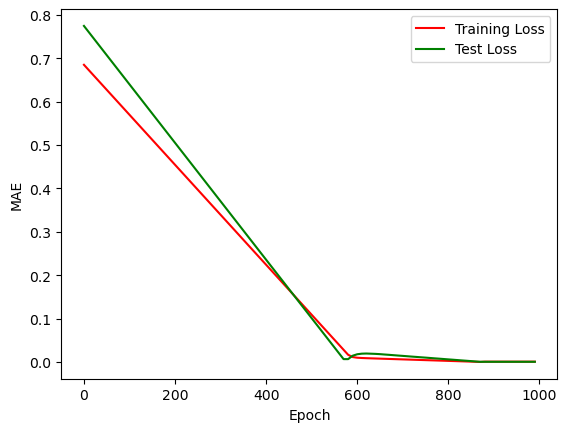

In [128]:
# Let's visualize the training and test loss:
fig, ax = plt.subplots()
ax.plot(epoch_num, train_losses, c='red', label='Training Loss')
ax.plot(epoch_num, test_losses, c='green', label='Test Loss')
ax.legend()
ax.set_xlabel('Epoch')
ax.set_ylabel('MAE')
plt.show()

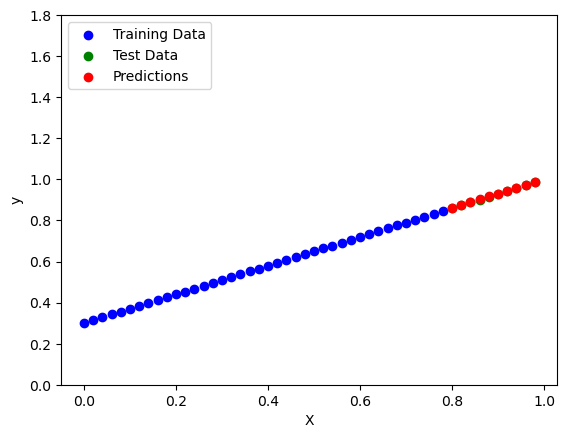

In [129]:
# Let's visualize the accuracy of the predictions relative to ground truth:
plot_data(predictions=test_pred)

In [131]:
# Find our model's learned parameters
print("The model learned the following values for weights and bias:")
print(model_0.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('weights', tensor([0.6999])), ('bias', tensor([0.3009]))])

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


### Saving a PyTorch model

The recommended way to save a model is by saving and loading the model's state dictionary using `torch.save(model_name.state_dict(), save_path)`. This contains all the information about the model's parameters.

In [133]:
from pathlib import Path

MODEL_PATH = Path('models')
MODEL_PATH.mkdir(parents = True, exist_ok=True)
MODEL_NAME = '01_pytorch_workflow_model_0.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f'Saving model to {MODEL_SAVE_PATH}')
torch.save( obj = model_0.state_dict(), # only saving the learned parameters
            f = MODEL_SAVE_PATH)

Saving model to models/01_pytorch_workflow_model_0.pth


### Loading a PyTorch model

Since we've now got a saved model `state_dict()` at `models/01_pytorch_workflow_model_0.pth` we can now load it in using `torch.nn.Module.load_state_dict(torch.load(f))` where f is the filepath of our saved model `state_dict()`

Why not just save the entire model? This works also, but is more brittle and prone to errors. The preferred approach is to make a new object of the model class, and then load the state dictionary into that object.

In [134]:
# let's create a new model:
loaded_model_0 = LinearRegressionModel()

# and load the learned parameters into it:
loaded_model_0.load_state_dict(torch.load(MODEL_SAVE_PATH))

<All keys matched successfully>

Let's evaluate the loaded model and make sure it's working correctly:

In [136]:
# put model into eval/inf mode:
loaded_model_0.eval()
with torch.inference_mode():
    loaded_model_0_pred = loaded_model_0(X_test)

# See is the loaded predictions are the same as the original predictions:
# NOTE: torch.allclose() refturns True if two arrays are equal within rel and abs tolerance (default 1e-5 and 1d-8)
print(f'Are the loaded predictions the same as the original predictions? {torch.allclose(loaded_model_0_pred, test_pred)}')

Are the loaded predictions the same as the original predictions? True


# Polynomial

In [ ]:
# f(x) = 2x^6, 